# Project 1 NLA: direct methods in optimization with constraints

## **C0:** Initialization

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.linalg import ldl, solve_triangular
from numpy.linalg import norm, solve, cholesky, cond
from tqdm import tqdm

Here follow different general functions that will be used throughout the project

In [3]:
def update_MKKT(MKKT, lamb, s):
  ''' update_MKKT
  Updates the matrix of the KKT system with the given values of s and lambda
  Given G, A, C, s, lamb, Returns the MKKT Matrix
  '''

  # Retrieve the value of m ----------------------------------------------------
  m = len(s)

  # Update the matrix ----------------------------------------------------------
  MKKT[-m:, -2*m:-m] = np.eye(m)*s
  MKKT[-m:, -m:] = np.eye(m)*lamb

  kond = cond(MKKT)
  
  return MKKT, kond

## **C1:** Write down a routine function that implements the step-size substep.

In [4]:
# Define the function to compute alpha for the correction substep --------------
def Newton_step(lamb0, dlamb, s0, ds):
  ''' Newton_step
  This function computes alpha for the step-size correction substep
  Given lamb0, dlamb, s0, ds, returns alpha
  '''
  alp=1
  idx_lamb0=np.array(np.where(dlamb<0))
  if idx_lamb0.size>0:
      alp = min(alp,np.min(-lamb0[idx_lamb0]/dlamb[idx_lamb0]))
  
  idx_s0=np.array(np.where(ds<0))
  if idx_s0.size>0:
      alp = min(alp,np.min(-s0[idx_s0]/ds[idx_s0]))
      
  return alp

## **C2:**  Write down a program that, for a given n, implements the full algorithm for the test problem. Use the numpy.linalg.solve function to solve the KKT linear systems of the predictor and corrector substeps directly

For an easier use we can define a function to generate a test problem of dimension n. This will be used later for studying the behavior of the method applied to test problems of different sizes n

In [5]:
# Defining a function to generate the test problem for a size n ----------------
def test_prob_gen(n=2):
  # Defining the test problem ----------------------------------------------------
  m = 2*n

  G = np.eye(n)
  g = np.random.normal(0, 1, n).reshape([n,1])
  C = np.block([ [np.eye(n), -np.eye(n)] ])
  d = -10*np.ones([m,1])

  # Initializing the initial values ----------------------------------------------
  x0 = np.zeros([n,1])
  s0 = np.ones([m,1])
  lamb0 = np.ones([m,1])

  return G, g, C, d, x0, lamb0, s0

In this section we will test the algorithm on a test problem of size n=3. Its performance on test problems of different sizes n will be assessed later in the following sections

In [6]:
n=3
G, g, C, d, x0, lamb0, s0 = test_prob_gen(n)

In the following are defined the functions of F(z) and to compose MKKT matrix restricted to inequality constrains (i.e. A=0)

In [7]:
def F_cut(G, g, C, d, z):
  ''' F_cut
  Computes the value of F for the probem with matrices G, g, A, b, C, d, restricted to inequality constrains (i.e. A=0)
  Given the values of z, Returns the value of F(z) 
  '''

  # Retrieve the dimensions of the matrices ------------------------------------
  n = G.shape[0]
  m = C.shape[1]
  N = n+2*m

  # Compose the output vector F(z) ---------------------------------------------
  res = np.zeros([N,1])
  res[:n] = np.dot(G,z[:n])+g-np.dot(C,z[n:n+m])
  res[n:n+m] = z[n+m:]+d-np.dot(C.T,z[:n])
  res[n+m:] = z[n+m:]*z[n:n+m]

  return res

def compose_MKKT_cut(G, C, lamb, s):
  ''' compose_MKKT
  Computes the matrix of the KKT system with the given values of s and lambda, restricted to inequality constrains (i.e. A=0)
  Given G, C, s, lamb, Returns the MKKT Matrix
  '''

  # Retrieve the dimensions of the matrices ------------------------------------
  n = G.shape[0]
  m = C.shape[1]

  MKKT = np.block([
                  [G,               -C,              np.zeros([n,m])  ],
                  [-C.T,            np.zeros([m,m]), np.eye(m)        ],
                  [np.zeros([m,n]), np.eye(m)*s,     np.eye(m)*lamb   ]
                                                                      ])
  
  kond = cond(MKKT)
  
  return MKKT, kond

In [8]:
# Defining a function to run the method ----------------------------------------
def Newton_stepsize_S0(G, g, C, d, x0, lamb0, s0, max_iter = 100, epsilon = 1e-16):
  ''' Newton step-size
  The method is restricted to inequality constrains (i.e. A=0)
  Given G, g, C, d, x0, s0, lamb0, Returns the solution to the problem min( 1/2*x.T*G*x + g.T*x)
  '''

  # Retrieve the dimensions of the matrices ------------------------------------
  n = G.shape[0]
  m = C.shape[1]
  N = n+2*m

  # Initialization -------------------------------------------------------------
  z = np.concatenate((x0, lamb0, s0), axis=None).reshape([N,1])
  kond = []
  err = []
  MKKT, kond_t = compose_MKKT_cut(G, C, lamb0, s0)
  kond.append(kond_t)
  err.append(norm(z[:n]+g))
  n_iter = 0
  delta = np.ones([N,1])      # Initialized in order to enter the loop, then immediately updated
  mu = 1          # Initialized in order to enter the loop, then updated

  # Method ---------------------------------------------------------------------
  while norm(delta[:n])>epsilon and norm(delta[n:n+m])>epsilon and norm(delta[n+m:])>epsilon and abs(mu)>epsilon and n_iter < max_iter:
    rhv = -F_cut(G, g, C, d, z)     # Compute the right hand vector
    delta = solve(MKKT, rhv)        # Compute the newton step
    alpha = Newton_step(z[n:n+m].ravel(), delta[n:n+m].ravel(), z[n+m:].ravel(), delta[n+m:].ravel())       # compute the value of alpha

    mu = np.dot(z[n+m:].T, z[n:n+m])/m
    mu_tilda = np.dot( (z[n+m:]+alpha*delta[n+m:]).T, (z[n:n+m]+alpha*delta[n:n+m]) )/m
    sigma = (mu_tilda/mu)**3

    rhv[n+m:] = rhv[n+m:]-delta[n+m:]*delta[n:n+m]+sigma*mu*np.ones([m,1])         # Compute the modified right hand vector
    delta = solve(MKKT, rhv)       # Update the newton step
    alpha = Newton_step(z[n:n+m].ravel(), delta[n:n+m].ravel(), z[n+m:].ravel(), delta[n+m:].ravel())       # Update the value of alpha

    z = z + 0.95*alpha*delta              # take one step of the method
    MKKT, kond_t = update_MKKT(MKKT, z[n:n+m], z[n+m:])          # Update the MKKT matrix
    kond.append(kond_t)
    err.append(norm(z[:n]+g))    
    n_iter = n_iter+1

  return z, n_iter, kond, err

In [9]:
# Run the method on the test problem -------------------------------------------
n=3
G, g, C, d, x0, lamb0, s0 = test_prob_gen(n)
z, n_iter, kond, err = Newton_stepsize_S0(G, g, C, d, x0, lamb0, s0)

print("This is a test of the Newton_stepsize_S0 function, on a test problem of n=2. It terminates in", n_iter, "iterations")
print("The obtained solution is: ")
print(z[:n])
print("The exact solution of the problem is: ")
print(-g)

This is a test of the Newton_stepsize_S0 function, on a test problem of n=2. It terminates in 17 iterations
The obtained solution is: 
[[-0.95991279]
 [ 0.78732148]
 [-0.03260365]]
The exact solution of the problem is: 
[[-0.95991279]
 [ 0.78732148]
 [-0.03260365]]


## **C3:** Write a modification of the previous program **C2** to report the computation time of the solution of the test problem for different dimensions *n*.

In [10]:
import time

# Defining a function to run the method ----------------------------------------
def Newton_stepsize_S0_time(G, g, C, d, x0, lamb0, s0, max_iter = 50, epsilon = 1e-16):
  ''' Newton step-size
  The method is restricted to inequality constrains (i.e. A=0)
  Given G, g, C, d, x0, s0, lamb0, Returns the solution to the problem min( 1/2*x.T*G*x + g.T*x)
  '''

  # Start the timer ------------------------------------------------------------
  start = time.time()

  # Run the method -------------------------------------------------------------
  z, n_iter, kond, err = Newton_stepsize_S0(G, g, C, d, x0, lamb0, s0, max_iter, epsilon)

  # Stop the timer and print the time elapsed ----------------------------------
  end = time.time()
  comp_time = (end-start)*(10**3)

  return z, n_iter, comp_time, kond, err

In [11]:
# Run the method on the test problem -------------------------------------------
z, n_iter, comp_time, kond, err = Newton_stepsize_S0_time(G, g, C, d, x0, lamb0, s0)

print("Number of iterations: " + str(n_iter))
print("Time of execution: " + str(comp_time), "ms")

Number of iterations: 17
Time of execution: 7.326841354370117 ms


In the following the computational time and the number of iterations is studied on problems of size from n=1 to n=100

Text(0.5, 1.0, 'Computational time for problems of size n=[1,100]')

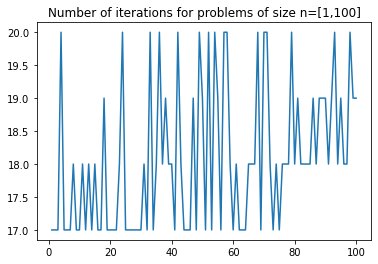

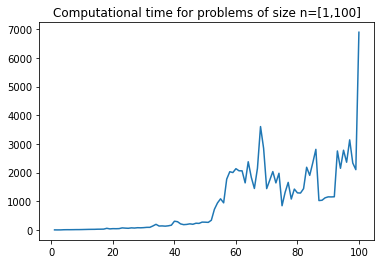

In [11]:
import matplotlib.pyplot as plt

# Run the method on problems of different sizes n ------------------------------
nn = np.arange(1, 101)             # An array with the dimensions n considered
n_iter = np.zeros([len(nn)])           # Initialize an array to store the values of the number of iterations
comp_time = np.zeros([len(nn)])          # Initialize an array to store the computational time 

for i in range(0, len(nn)):
  G, g, C, d, x0, s0, lamb0 = test_prob_gen(nn[i])
  z, n_iter[i], comp_time[i], kond, err = Newton_stepsize_S0_time(G, g, C, d, x0, lamb0, s0)

# Visualize the results --------------------------------------------------------
plt.figure()
plt.plot(nn, n_iter)
plt.title("Number of iterations for problems of size n=[1,100]")

plt.figure()
plt.plot(nn, comp_time)
plt.title("Computational time for problems of size n=[1,100]")

The number of iterations and computational time depend not only on the algorithm but also on the problem. Since g is randomly generated, the problem on which the method is applied is not uniquely defined. Fort this reason, in the following section a computation of an average of the time and number of iterations is presented.

In [12]:
def Newton_stepsize_S0_avg_time(n_max=100, n_test=100):
  ''' Newton_S0_time
  Given a maximum dimension n and a number n_test, it computes the average computational time of the Newton_stepsize on a test problem of size n in [1,n_max] over n_test times
  Returns two arrays with the averages obtained in terms of iterations and time, n_iter and comp_time
  '''
  # Run the method on problems of different sizes n, n_test times, and get an average -
  nn = np.arange(1, n_max+1)             # An array with the dimensions n considered                     
  n_iter = np.zeros([len(nn)])           # Initialize an array to store the values of the number of iterations
  comp_time = np.zeros([len(nn)])          # Initialize an array to store the computational time 

  for i in range(0, len(nn)):
    n_iter_av = 0;
    comp_time_av = 0;
    for j in range(0, n_test+1):
      G, g, C, d, x0, s0, lamb0 = test_prob_gen(nn[i])
      z, n_iter_t, comp_time_t, kond, err  = Newton_stepsize_S0_time(G, g, C, d, x0, lamb0, s0)
      n_iter_av = n_iter_av + n_iter_t
      comp_time_av = comp_time_av + comp_time_t
    n_iter[i] = n_iter_av/n_test
    comp_time[i] = comp_time_av/n_test

  # Visualize the results --------------------------------------------------------
  plt.figure()
  plt.plot(nn, n_iter)
  plt.title("Average number of iterations for problems of size n=[1," + str(n_max) + "]")

  plt.figure()
  plt.plot(nn, comp_time)
  plt.title("Average computational time for problems of size n=[1," + str(n_max) + "]")

  return n_iter, comp_time

In [ ]:
n_iter_Newton_S0, comp_time_Newton_S0 = Newton_stepsize_S0_avg_time()

## **C4:** Write down two programs (modifications of **C2**) that solve the optimization problem for the test problem using the previous strategies. Report the computational time for different values of n and compare with the results in **C3**.


Strategy 1

In [13]:
# Composing the matrix for C4S1 ------------------------------------------------
def compose_C4S1(G, C, lamb, s):
  ''' compose_C4S1
  Computes the matrix C4S1 for point C4 Strategy 1, restricted to inequality constrains (i.e. A=0)
  Given G, C, s, lamb, Returns the C4S1 Matrix
  '''

  # Retrieve the dimensions of the matrices ------------------------------------
  n = G.shape[0]
  m = C.shape[1]

  C4S1 = np.block([
                  [G,    -C,                                  ],
                  [-C.T, -np.dot(np.eye(m)/lamb,np.eye(m)*s)  ]
                                                              ])
  
  kond = cond(C4S1)
    
  return C4S1, kond

def update_C4S1(C4S1, lamb, s):
  ''' update_C4S1
  Updates the matrix C4S1 with the given values of s and lambda
  Given C4S1, s, lamb, Returns the C4S1 Matrix updated
  '''

  # Retrieve the value of m ----------------------------------------------------
  m = len(s)

  # Update the matrix ----------------------------------------------------------
  C4S1[-m:, -m:] = -np.dot(np.eye(m)/lamb,np.eye(m)*s)

  kond = cond(C4S1)
  
  return C4S1, kond

In [14]:
# Defining a function to run the method ----------------------------------------
def Newton_stepsize_S1(G, g, C, d, x0, lamb0, s0, max_iter = 100, epsilon = 1e-16):
  ''' Newton step-size with strategy 1
  The method is restricted to inequality constrains (i.e. A=0)
  Given G, g, C, d, x0, s0, lamb0, Returns the solution to the problem min( 1/2*x.T*G*x + g.T*x)
  '''

  # Retrieve the dimensions of the matrices ------------------------------------
  n = G.shape[0]
  m = C.shape[1]
  N = n+2*m

  # Initialization -------------------------------------------------------------
  z = np.concatenate((x0, lamb0, s0), axis=None).reshape([N,1])
  kond = []
  err = []
  C4S1, kond_t = compose_C4S1(G, C, lamb0, s0)
  kond.append(kond_t)
  err.append(norm(z[:n]+g))
  n_iter = 0
  delta = np.ones([N,1])      # Initialized in order to enter the loop, then immediately updated
  mu = 1          # Initialized in order to enter the loop, then updated

  # Method ---------------------------------------------------------------------
  while norm(delta[:n])>epsilon and norm(delta[n:n+m])>epsilon and norm(delta[n+m:])>epsilon and abs(mu)>epsilon and n_iter < max_iter:
    rhv = -F_cut(G, g, C, d, z)     # Compute the right hand vector
    rhv2d = np.concatenate((rhv[:n], rhv[n:n+m]-np.dot((np.eye(m)/z[n:n+m]),rhv[n+m:])), axis=None).reshape([n+m,1])        # Right hand vector to solve C4S1

    L, D, perm = ldl(C4S1)
    #invperm = np.empty(perm.size, dtype=np.int32)     # inverse permutation array
    #for i in np.arange(perm.size):
    #  invperm[perm[i]] = i
    #aux = solve_triangular(L[perm,:], rhv2d[perm], lower=True)
    #aux = (aux)/(np.diag(D).reshape([n+m,1]))
    #delta[:n+m] = solve_triangular(L.T[:,perm], aux, lower=False)[invperm]        # Compute delta_x and delta_lambda
    aux = solve_triangular(L, rhv2d, lower=True)
    aux = (aux)/(np.diag(D).reshape([n+m,1]))
    delta[:n+m] = solve_triangular(L.T, aux, lower=False)        # Compute delta_x and delta_lambda
    delta[-m:] = np.dot((np.eye(m)/z[n:n+m]),(rhv[-m:]-z[-m:]*delta[n:n+m]))            # Compute the value of delta_s

    alpha = Newton_step(z[n:n+m].ravel(), delta[n:n+m].ravel(), z[n+m:].ravel(), delta[n+m:].ravel())       # compute the value of alpha

    mu = np.dot(z[n+m:].T,z[n:n+m])/m
    mu_tilda = np.dot((z[n+m:]+alpha*delta[n+m:]).T,z[n:n+m]+alpha*delta[n:n+m])/m
    sigma = (mu_tilda/mu)**3

    rhv[n+m:] = rhv[n+m:]-delta[n+m:]*delta[n:n+m]+sigma*mu*np.ones([m,1])         # Compute the modified right hand vector
    rhv2d = np.concatenate((rhv[:n], rhv[n:n+m]-np.dot((np.eye(m)/z[n:n+m]),rhv[n+m:])), axis=None).reshape([n+m,1])        # Right hand vector to solve C4S1

    L, D, perm = ldl(C4S1)
    #invperm = np.empty(perm.size, dtype=np.int32)     # inverse permutation array
    #for i in np.arange(perm.size):
    #  invperm[perm[i]] = i
    #aux = solve_triangular(L[perm,:], rhv2d[perm], lower=True)
    #aux = (aux)/(np.diag(D).reshape([n+m,1]))
    #delta[:n+m] = solve_triangular(L.T[:,perm], aux, lower=False)[invperm]        # Compute delta_x and delta_lambda
    aux = solve_triangular(L, rhv2d, lower=True)
    aux = (aux)/(np.diag(D).reshape([n+m,1]))
    delta[:n+m] = solve_triangular(L.T, aux, lower=False)        # Compute delta_x and delta_lambda
    delta[-m:] = np.dot((np.eye(m)/z[n:n+m]),(rhv[-m:]-z[-m:]*delta[n:n+m]))            # Compute the value of delta_s

    alpha = Newton_step(z[n:n+m].ravel(), delta[n:n+m].ravel(), z[n+m:].ravel(), delta[n+m:].ravel())       # Update the value of alpha

    z = z + 0.95*alpha*delta              # take one step of the method
    C4S1, kond_t = update_C4S1(C4S1, z[n:n+m], z[n+m:])          # Update the C4S1 matrix
    kond.append(kond_t)
    err.append(norm(z[:n]+g))
    n_iter = n_iter+1

  return z, n_iter, kond, err

In [15]:
# Run the method on the test problem -------------------------------------------
n=3
G, g, C, d, x0, lamb0, s0 = test_prob_gen(n)
z, n_iter, kond, err = Newton_stepsize_S1(G, g, C, d, x0, lamb0, s0)

print("This is a test of the Newton_stepsize_S0 function, on a test problem of n=2. It terminates in", n_iter, "iterations")
print("The obtained solution is: ")
print(z[:n])
print("The exact solution of the problem is: ")
print(-g)

This is a test of the Newton_stepsize_S0 function, on a test problem of n=2. It terminates in 17 iterations
The obtained solution is: 
[[-1.35814663]
 [-0.39976544]
 [-1.84767545]]
The exact solution of the problem is: 
[[-1.35814663]
 [-0.39976544]
 [-1.84767545]]


Strategy 2

In [16]:
# Composing the matrix for C4S2 ------------------------------------------------
def compose_C4S2(G, C, lamb, s):
  ''' compose_C4S2
  Computes the matrix C4S2 for point C4 Strategy 1, restricted to inequality constrains (i.e. A=0)
  Given G, C, s, lamb, Returns the C4S2 Matrix
  '''

  # Retrieve the dimensions of the matrices ------------------------------------
  n = G.shape[0]
  m = C.shape[1]

  C4S2 = G + np.dot(C, np.dot(lamb/s*np.eye(m), C.T))

  kond = cond(C4S2)
    
  return C4S2, kond

In [17]:
# Defining a function to run the method ----------------------------------------
def Newton_stepsize_S2(G, g, C, d, x0, lamb0, s0, max_iter = 100, epsilon = 1e-16):
  ''' Newton step-size with strategy 1
  The method is restricted to inequality constrains (i.e. A=0)
  Given G, g, C, d, x0, s0, lamb0, Returns the solution to the problem min( 1/2*x.T*G*x + g.T*x)
  '''

  # Retrieve the dimensions of the matrices ------------------------------------
  n = G.shape[0]
  m = C.shape[1]
  N = n+2*m

  # Initialization -------------------------------------------------------------
  z = np.concatenate((x0, lamb0, s0), axis=None).reshape([N,1])
  kond = []
  err = []
  G_hat, kond_t = compose_C4S2(G, C, lamb0, s0)
  kond.append(kond_t)
  err.append(norm(z[:n]+g))
  n_iter = 0
  delta = np.ones([N,1])      # Initialized in order to enter the loop, then immediately updated
  mu = 1          # Initialized in order to enter the loop, then updated

  # Method ---------------------------------------------------------------------
  while norm(delta[:n])>epsilon and norm(delta[n:n+m])>epsilon and norm(delta[n+m:])>epsilon and abs(mu)>epsilon and n_iter < max_iter:
    rhv = F_cut(G, g, C, d, z)     # Compute the right hand vector
    r1 = rhv[:n]              # Decompose the right hand vector
    r2 = rhv[n:n+m]
    r3 = rhv[-m:]
    r_hat = -np.dot(np.dot(C,np.eye(m)/z[-m:]), -r3+z[n:n+m]*r2)        # Right hand vector to solve C4S2

  # Compute the Cholesky factorization -----------------------------------------
    L = cholesky(G_hat)           # Cholesky factorization
    aux = solve_triangular(L, -r1-r_hat, lower=True)       # Solve the system with the Cholesky factorization
    delta_x = solve_triangular(L.T, aux, lower=False)        # Compute delta_x

  # Compute the rest of delta_z and alpha --------------------------------------
    delta_l = np.dot(np.eye(m)/z[-m:], -r3+z[n:n+m]*r2)-np.dot(np.eye(m)/z[-m:],np.dot(np.eye(m)*z[n:n+m],np.dot(C.T,delta_x)))     # Compute delta_lambda
    delta_s = -r2+np.dot(C.T,delta_x)             # Compute delta_s
    delta = np.concatenate((delta_x, delta_l, delta_s), axis=None).reshape([N,1])       # Re-compose the delta_z vector

    alpha = Newton_step(z[n:n+m].ravel(), delta[n:n+m].ravel(), z[n+m:].ravel(), delta[n+m:].ravel())       # compute the value of alpha

  # Compute mu, mu_tilda, sigma ------------------------------------------------
    mu = np.dot(z[n+m:].T,z[n:n+m])/m
    mu_tilda = np.dot((z[n+m:]+alpha*delta[n+m:]).T,z[n:n+m]+alpha*delta[n:n+m])/m
    sigma = (mu_tilda/mu)**3

    rhv[n+m:] = rhv[n+m:]+delta[n+m:]*delta[n:n+m]-sigma*mu*np.ones([m,1])         # Compute the modified right hand vector (now it does not include the negative sign)
    r1 = rhv[:n]              # Decompose the right hand vector
    r2 = rhv[n:n+m]
    r3 = rhv[-m:]
    r_hat = -np.dot(np.dot(C,np.eye(m)/z[-m:]), -r3+z[n:n+m]*r2)        # Right hand vector to solve C4S2

  # Compute the Cholesky factorization -----------------------------------------
    L = cholesky(G_hat)           # Cholesky factorization
    aux = solve_triangular(L, -r1-r_hat, lower=True)       # Solve the system with the Cholesky factorization
    delta_x = solve_triangular(L.T, aux, lower=False)        # Compute delta_x

  # Compute the rest of delta_z and alpha --------------------------------------
    delta_l = np.dot(np.eye(m)/z[-m:], -r3+z[n:n+m]*r2)-np.dot(np.eye(m)/z[-m:],np.dot(np.eye(m)*z[n:n+m],np.dot(C.T,delta_x)))     # Compute delta_lambda
    delta_s = -r2+np.dot(C.T,delta_x)             # Compute delta_s
    delta = np.concatenate((delta_x, delta_l, delta_s), axis=None).reshape([N,1])       # Re-compose the delta_z vector
    
    alpha = Newton_step(z[n:n+m].ravel(), delta[n:n+m].ravel(), z[n+m:].ravel(), delta[n+m:].ravel())       # Update the value of alpha

  # Update ---------------------------------------------------------------------
    z = z + 0.95*alpha*delta              # take one step of the method
    G_hat, kond_t = compose_C4S2(G, C, z[n:n+m], z[n+m:])          # Update the C4S2 matrix
    kond.append(kond_t)
    err.append(norm(z[:n]+g))
    n_iter = n_iter+1

  return z, n_iter, kond, err

In [18]:
# Run the method on the test problem -------------------------------------------
n=3
G, g, C, d, x0, lamb0, s0 = test_prob_gen(n)
z, n_iter, kond, err = Newton_stepsize_S2(G, g, C, d, x0, lamb0, s0)

print("This is a test of the Newton_stepsize_S0 function, on a test problem of n=2. It terminates in", n_iter, "iterations")
print("The obtained solution is: ")
print(z[:n])
print("The exact solution of the problem is: ")
print(-g)

This is a test of the Newton_stepsize_S0 function, on a test problem of n=2. It terminates in 17 iterations
The obtained solution is: 
[[-1.76182465]
 [-2.10396422]
 [ 1.17168947]]
The exact solution of the problem is: 
[[-1.76182465]
 [-2.10396422]
 [ 1.17168947]]


Computational time of S1 and S2

In [19]:
import time

# Defining a function to run the method ----------------------------------------
def Newton_stepsize_S1_time(G, g, C, d, x0, lamb0, s0, max_iter = 100, epsilon = 1e-16):
  ''' Newton step-size with strategy 1
  The method is restricted to inequality constrains (i.e. A=0)
  Given G, g, C, d, x0, s0, lamb0, Returns the solution to the problem min( 1/2*x.T*G*x + g.T*x)
  '''

  # Start the timer ------------------------------------------------------------
  start = time.time()

  # Run the method -------------------------------------------------------------
  z, n_iter, kond, err = Newton_stepsize_S1(G, g, C, d, x0, lamb0, s0, max_iter, epsilon)

  # Stop the timer and print the time elapsed ----------------------------------
  end = time.time()
  comp_time = (end-start)*(10**3)

  return z, n_iter, comp_time, kond, err

In [20]:
import time

# Defining a function to run the method ----------------------------------------
def Newton_stepsize_S2_time(G, g, C, d, x0, lamb0, s0, max_iter = 100, epsilon = 1e-16):
  ''' Newton step-size with strategy 1
  The method is restricted to inequality constrains (i.e. A=0)
  Given G, g, C, d, x0, s0, lamb0, Returns the solution to the problem min( 1/2*x.T*G*x + g.T*x)
  '''

  # Start the timer ------------------------------------------------------------
  start = time.time()

  # Run the method -------------------------------------------------------------
  z, n_iter, kond, err = Newton_stepsize_S2(G, g, C, d, x0, lamb0, s0, max_iter, epsilon)

  # Stop the timer and print the time elapsed ----------------------------------
  end = time.time()
  comp_time = (end-start)*(10**3)

  return z, n_iter, comp_time, kond, err

In [21]:
# Run the methods on the test problem ------------------------------------------
z, n_iter_S0, comp_time_S0, kond_S0, err_S0 = Newton_stepsize_S0_time(G, g, C, d, x0, lamb0, s0)
z, n_iter_S1, comp_time_S1, kond_S1, err_S1 = Newton_stepsize_S1_time(G, g, C, d, x0, lamb0, s0)
z, n_iter_S2, comp_time_S2, kond_S2, err_S2 = Newton_stepsize_S2_time(G, g, C, d, x0, lamb0, s0)

print("Number of iterations S0: " + str(n_iter_S0))
print("Time of execution S0: " + str(comp_time_S0), "ms")


print("Number of iterations S1: " + str(n_iter_S1))
print("Time of execution S1: " + str(comp_time_S1), "ms")

print("Number of iterations S2: " + str(n_iter_S2))
print("Time of execution S2: " + str(comp_time_S2), "ms")

Number of iterations S0: 17
Time of execution S0: 9.243011474609375 ms
Number of iterations S1: 17
Time of execution S1: 13.162851333618164 ms
Number of iterations S2: 17
Time of execution S2: 8.13746452331543 ms


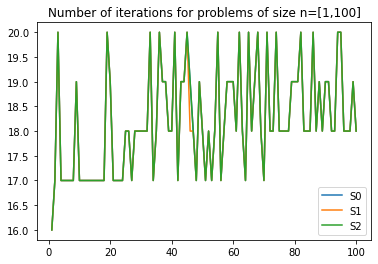

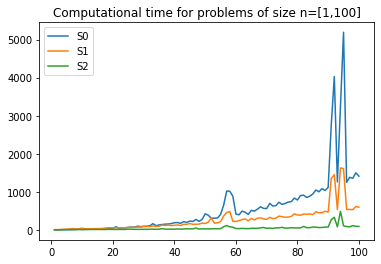

In [22]:
import matplotlib.pyplot as plt

# Run the method on problems of different sizes n ------------------------------
nn = np.arange(1, 101)             # An array with the dimensions n considered
n_iter_S0 = np.zeros([len(nn)])           # Initialize an array to store the values of the number of iterations
comp_time_S0 = np.zeros([len(nn)])          # Initialize an array to store the computational time 
n_iter_S1 = np.zeros([len(nn)])           # Initialize an array to store the values of the number of iterations
comp_time_S1 = np.zeros([len(nn)])          # Initialize an array to store the computational time 
n_iter_S2 = np.zeros([len(nn)])           # Initialize an array to store the values of the number of iterations
comp_time_S2 = np.zeros([len(nn)])          # Initialize an array to store the computational time 

for i in range(0, len(nn)):
  G, g, C, d, x0, s0, lamb0 = test_prob_gen(nn[i])
  z, n_iter_S0[i], comp_time_S0[i], kond, err = Newton_stepsize_S0_time(G, g, C, d, x0, lamb0, s0)
  z, n_iter_S1[i], comp_time_S1[i], kond, err = Newton_stepsize_S1_time(G, g, C, d, x0, lamb0, s0)
  z, n_iter_S2[i], comp_time_S2[i], kond, err = Newton_stepsize_S2_time(G, g, C, d, x0, lamb0, s0)


# Visualize the results --------------------------------------------------------
plt.figure()
plt.plot(nn, n_iter_S0)
plt.plot(nn, n_iter_S1)
plt.plot(nn, n_iter_S2)
plt.title("Number of iterations for problems of size n=[1,100]")
plt.legend(["S0", "S1", "S2"])

plt.figure()
plt.plot(nn, comp_time_S0)
plt.plot(nn, comp_time_S1)
plt.plot(nn, comp_time_S2)
plt.title("Computational time for problems of size n=[1,100]")
plt.legend(["S0", "S1", "S2"])

In [23]:
def Newton_S0S1S2_avg_time(n_max=100, n_test=100):
  ''' Newton_avg_time
  Given a maximum dimension n and a number n_test, it computes the average computational time of the Newton_stepsize on a test problem of size n in [1,n_max] over n_test times
  Returns two arrays with the averages obtained in terms of iterations and time, n_iter and comp_time
  '''
  # Run the method on problems of different sizes n, n_test times, and get an average -
  nn = np.arange(1, n_max+1)             # An array with the dimensions n considered                     
  n_iter_S0 = np.zeros([len(nn)])           # Initialize an array to store the values of the number of iterations
  comp_time_S0 = np.zeros([len(nn)])          # Initialize an array to store the computational time 
  n_iter_S1 = np.zeros([len(nn)])           # Initialize an array to store the values of the number of iterations
  comp_time_S1 = np.zeros([len(nn)])          # Initialize an array to store the computational time 
  n_iter_S2 = np.zeros([len(nn)])           # Initialize an array to store the values of the number of iterations
  comp_time_S2 = np.zeros([len(nn)])          # Initialize an array to store the computational time 

  for i in range(0, len(nn)):
    n_iter_S0_av = 0;
    comp_time_S0_av = 0;
    n_iter_S1_av = 0;
    comp_time_S1_av = 0;
    n_iter_S2_av = 0;
    comp_time_S2_av = 0;
    for j in range(0, n_test+1):
      G, g, C, d, x0, s0, lamb0 = test_prob_gen(nn[i])
      z, n_iter_S0_t, comp_time_S0_t, kond, err  = Newton_stepsize_S0_time(G, g, C, d, x0, lamb0, s0)
      z, n_iter_S1_t, comp_time_S1_t, kond, err  = Newton_stepsize_S1_time(G, g, C, d, x0, lamb0, s0)
      z, n_iter_S2_t, comp_time_S2_t, kond, err  = Newton_stepsize_S2_time(G, g, C, d, x0, lamb0, s0)

      n_iter_S0_av = n_iter_S0_av + n_iter_S0_t
      n_iter_S1_av = n_iter_S1_av + n_iter_S1_t
      n_iter_S2_av = n_iter_S2_av + n_iter_S2_t
      comp_time_S0_av = comp_time_S0_av + comp_time_S0_t
      comp_time_S1_av = comp_time_S1_av + comp_time_S1_t
      comp_time_S2_av = comp_time_S2_av + comp_time_S2_t

    n_iter_S0[i] = n_iter_S0_av/n_test
    comp_time_S0[i] = comp_time_S0_av/n_test
    n_iter_S1[i] = n_iter_S1_av/n_test
    comp_time_S1[i] = comp_time_S1_av/n_test
    n_iter_S2[i] = n_iter_S2_av/n_test
    comp_time_S2[i] = comp_time_S2_av/n_test

  return n_iter_S0, comp_time_S0, n_iter_S1, comp_time_S1, n_iter_S2, comp_time_S2

In [25]:
n_max = 100
n_test = 20
n_iter_S0, comp_time_S0, n_iter_S1, comp_time_S1, n_iter_S2, comp_time_S2 = Newton_S0S1S2_avg_time(n_max, n_test)

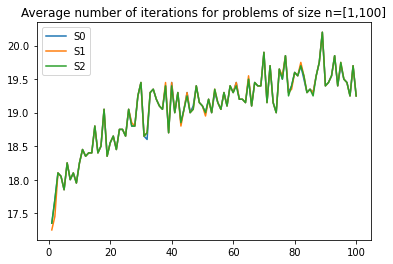

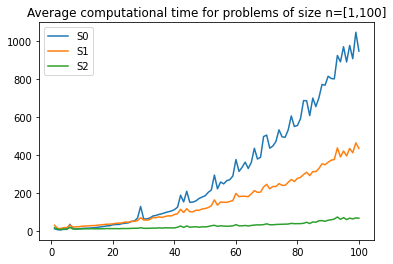

In [26]:
# Visualize the results --------------------------------------------------------
plt.figure()
plt.plot(nn, n_iter_S0)
plt.plot(nn, n_iter_S1)
plt.plot(nn, n_iter_S2)
plt.title("Average number of iterations for problems of size n=[1," + str(n_max) + "]")
plt.legend(["S0", "S1", "S2"])

plt.figure()
plt.plot(nn, comp_time_S0)
plt.plot(nn, comp_time_S1)
plt.plot(nn, comp_time_S2)
plt.title("Average computational time for problems of size n=[1," + str(n_max) + "]")
plt.legend(["S0", "S1", "S2"])

Robustness of the methods

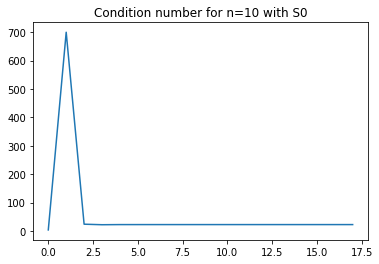

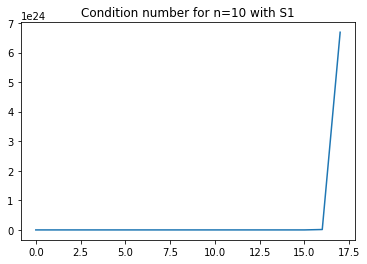

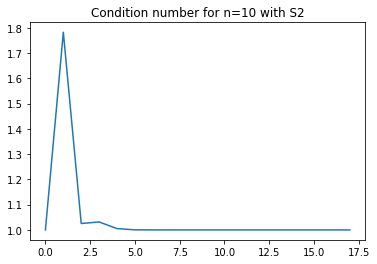

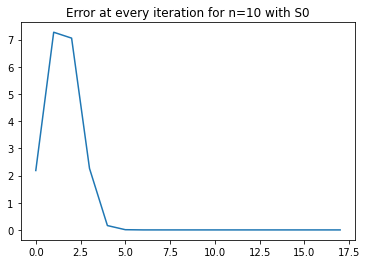

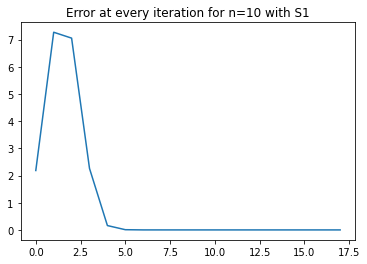

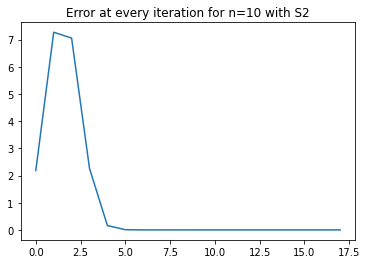

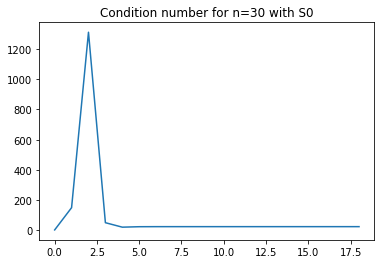

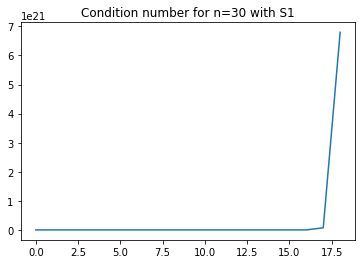

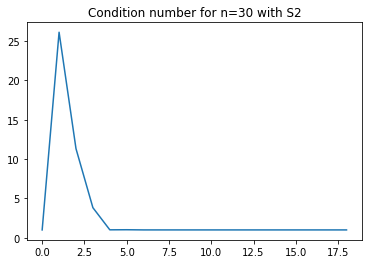

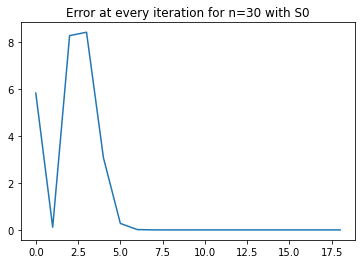

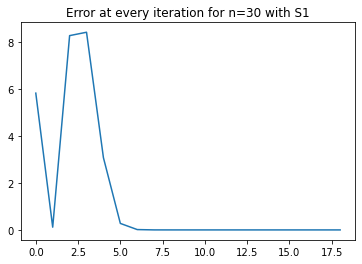

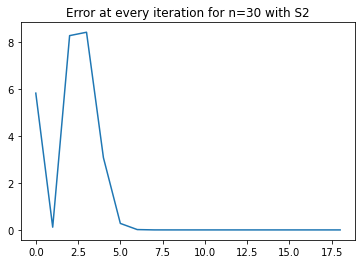

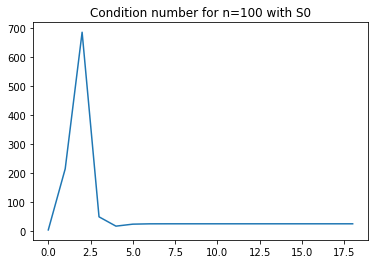

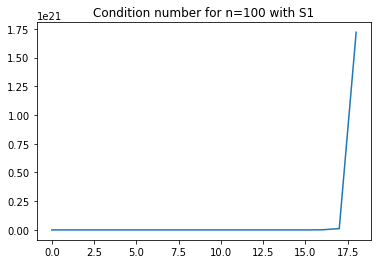

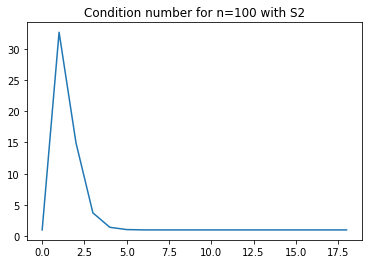

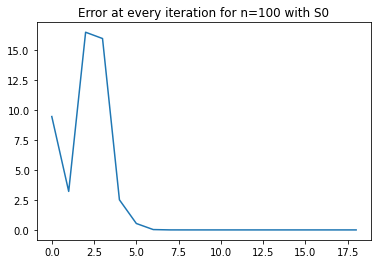

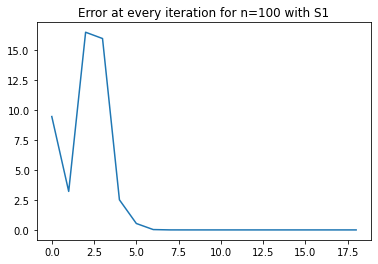

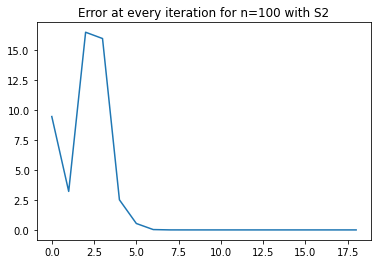

In [33]:
nn = [10, 30, 100]

for i in range(0, len(nn)):
  G, g, C, d, x0, s0, lamb0 = test_prob_gen(nn[i])
  z, n_iter_S0, comp_time_S0, kond_S0, err_S0  = Newton_stepsize_S0_time(G, g, C, d, x0, lamb0, s0)
  z, n_iter_S1, comp_time_S1, kond_S1, err_S1  = Newton_stepsize_S1_time(G, g, C, d, x0, lamb0, s0)
  z, n_iter_S2, comp_time_S2, kond_S2, err_S2  = Newton_stepsize_S2_time(G, g, C, d, x0, lamb0, s0)

  plt.figure()
  plt.plot(np.arange(len(kond_S0)), kond_S0)
  plt.title("Condition number for n=" + str(nn[i]) + " with S0")
  plt.figure()
  plt.plot(np.arange(len(kond_S1)), kond_S1)
  plt.title("Condition number for n=" + str(nn[i]) + " with S1")
  plt.figure()
  plt.plot(np.arange(len(kond_S2)), kond_S2)
  plt.title("Condition number for n=" + str(nn[i]) + " with S2")

  plt.figure()
  plt.plot(np.arange(len(err_S0)), err_S0)
  plt.title("Error at every iteration for n=" + str(nn[i]) + " with S0")
  plt.figure()
  plt.plot(np.arange(len(err_S1)), err_S1)
  plt.title("Error at every iteration for n=" + str(nn[i]) + " with S1")
  plt.figure()
  plt.plot(np.arange(len(err_S2)), err_S2)
  plt.title("Error at every iteration for n=" + str(nn[i]) + " with S2")

## **C5:** Write down a program that solves the optimization problem for the general case. Use numpy.linalg.solve function. Read the data of the optimization problems from the files (available at the Campus Virtual). Each problem consists on a collection of files: G.dad, g.dad, A.dad, b.dad, C.dad and d.dad. They contain the corresponding data in coordinate format. Take as initial condition x0 = (0, . . . , 0) and s0 = γ0 = λ0 = (1, . . . , 1) for all problems.


In [24]:
def F(G, g, A, b, C, d, z):
  ''' F
  Computes the value of F for the probem with matrices G, g, A, b, C, d
  Given the values of z, Returns the value of F(z) 
  '''

  # Retrieve the dimensions of the matrices ------------------------------------
  n = G.shape[0]
  p = A.shape[1]
  m = C.shape[1]
  N = n+p+2*m

  # Compose the output vector F(z) ---------------------------------------------
  res = np.zeros([N,1])
  res[:n] = np.dot(G,z[0:n])+g-np.dot(A,z[n:n+p])-np.dot(C,z[n+p:n+p+m])
  res[n:n+p] = b-np.dot(A.T,z[0:n])
  res[n+p:n+p+m] = z[n+p+m:]+d-np.dot(C.T,z[0:n])
  res[n+p+m:] = z[n+p+m:]*z[n+p:n+p+m]

  return res

def compose_MKKT(G, A, C, lamb, s):
  ''' compose_MKKT
  Computes the matrix of the KKT system with the given values of s and lambda
  Given G, A, C, s, lamb, Returns the MKKT Matrix
  '''

  # Retrieve the dimensions of the matrices ------------------------------------
  n = G.shape[0]
  p = A.shape[1]
  m = C.shape[1]

  MKKT = np.block([
                  [G,               -A,              -C,              np.zeros([n,m]) ],
                  [-A.T,            np.zeros([p,p]), np.zeros([p,m]), np.zeros([p,m]) ],
                  [-C.T,            np.zeros([m,p]), np.zeros([m,m]), np.eye(m)       ],
                  [np.zeros([m,n]), np.zeros([m,p]), np.eye(m)*s,     np.eye(m)*lamb  ]
                                                                                      ])
  
  kond = cond(MKKT)

  return MKKT, kond

In [34]:
# Defining a function to run the method ----------------------------------------
def Newton_stepsize_full_S0(G, g, A, b, C, d, x0, gamma0, lamb0, s0, ex_sol = 0, max_iter = 100, epsilon = 1e-16):
  ''' Newton step-size
  The method solves the KKT System using Newton's method with step-size correction
  Given G, g, A, b, C, d, x0, s0, lamb0, Returns the solution to the problem min(1/2*x.T*G*x + g.T*x)
  '''

  # Retrieve the dimensions of the matrices ------------------------------------
  n = G.shape[0]
  p = A.shape[1]
  m = C.shape[1]
  N = n+p+2*m

  # Initialization -------------------------------------------------------------
  z = np.concatenate((x0, gamma0, lamb0, s0), axis=None).reshape([N,1])
  kond = []
  err = []
  MKKT, kond_t = compose_MKKT(G, A, C, lamb0, s0)
  kond.append(kond_t)
  err.append(float(abs(1/2*(z[:n].T).dot(G).dot(z[:n])+(g.T).dot(z[:n])-ex_sol)))
  n_iter = 0
  delta = np.ones([N,1])      # Initialized in order to enter the loop, then immediately updated
  mu = 1          # Initialized in order to enter the loop, then updated

  # Method ---------------------------------------------------------------------
  while norm(delta[:n])>epsilon and norm(delta[n:n+m])>epsilon and norm(delta[n+m:])>epsilon and abs(mu)>epsilon and n_iter < max_iter:
    rhv = -F(G, g, A, b, C, d, z)     # Compute the right hand vector
    delta = solve(MKKT, rhv)        # Compute the newton step
    alpha = Newton_step(z[n+p:n+p+m].ravel(), delta[n+p:n+p+m].ravel(), z[n+p+m:].ravel(), delta[n+p+m:].ravel())       # compute the value of alpha

    mu = np.dot(z[n+p+m:].T,z[n+p:n+p+m])/m
    mu_tilda = np.dot((z[n+p+m:]+alpha*delta[n+p+m:]).T,z[n+p:n+p+m]+alpha*delta[n+p:n+p+m])/m
    sigma = (mu_tilda/mu)**3

    rhv[n+p+m:] = rhv[n+p+m:]-delta[n+p+m:]*delta[n+p:n+p+m]+sigma*mu*np.ones([m,1])         # Compute the modified right hand vector
    delta = solve(MKKT, rhv)       # Update the newton step
    alpha = Newton_step(z[n+p:n+p+m].ravel(), delta[n+p:n+p+m].ravel(), z[n+p+m:].ravel(), delta[n+p+m:].ravel())       # Update the value of alpha

    z = z + 0.95*alpha*delta              # take one step of the method
    MKKT, kond_t = update_MKKT(MKKT, z[n+p:n+p+m], z[n+p+m:])          # Update the MKKT matrix
    kond.append(kond_t)
    err.append(float(abs(1/2*(z[:n].T).dot(G).dot(z[:n])+(g.T).dot(z[:n])-ex_sol)))
    n_iter = n_iter+1

  return z, n_iter, kond, err

In [26]:
import time

# Defining a function to run the method ----------------------------------------
def Newton_stepsize_full_S0_time(G, g, A, b, C, d, x0, gamma0, lamb0, s0, ex_sol = 0, max_iter = 100, epsilon = 1e-16):
  ''' Newton step-size
  The method solves the KKT System using Newton's method with step-size correction
  Given G, g, A, b, C, d, x0, s0, lamb0, Returns the solution to the problem min(1/2*x.T*G*x + g.T*x)
  '''

  # Start the timer ------------------------------------------------------------
  start = time.time()

  # Run the method -------------------------------------------------------------
  z, n_iter, kond, err = Newton_stepsize_full_S0(G, g, A, b, C, d, x0, gamma0, lamb0, s0, ex_sol, max_iter, epsilon)

  # Stop the timer and print the time elapsed ----------------------------------
  end = time.time()
  comp_time = (end-start)*(10**3)

  return z, n_iter, comp_time, kond, err

In [27]:
# Function used in order to build the matrices of the problem from the data ----
import scipy.sparse as sp
def read_matrix(file, nrow, ncol):
  rows, cols, data = np.loadtxt(file, unpack=True)
  rows-=1
  cols-=1
  return sp.coo_matrix((data,(rows,cols)),shape=(nrow,ncol))

def read_vector(file, dim):
  sparse_vector = np.loadtxt(file, unpack=True)
  index = sparse_vector[0,:]-1
  values = sparse_vector[1,:]
  vector = np.zeros(dim)
  vector[index.astype(int)] = values
  return vector

In [28]:
# Initialize the first problem -------------------------------------------------
def initialize_P1():  
  n = 100
  p = 50
  m = 200

  G = read_matrix('/content/drive/MyDrive/10 - UB /20 - Colab Notebooks/UB Courses/Numerical Linear Algebra/Project_1/Problem1/G.dad', n, n).todense()
  G = G+G.T-np.diag(G)*np.eye(n)
  A = read_matrix('/content/drive/MyDrive/10 - UB /20 - Colab Notebooks/UB Courses/Numerical Linear Algebra/Project_1/Problem1/A.dad', n, p).todense()
  C = read_matrix('/content/drive/MyDrive/10 - UB /20 - Colab Notebooks/UB Courses/Numerical Linear Algebra/Project_1/Problem1/C.dad', n, m).todense()

  g = read_vector('/content/drive/MyDrive/10 - UB /20 - Colab Notebooks/UB Courses/Numerical Linear Algebra/Project_1/Problem1/g_vector.dad', n).reshape([n,1])
  b = read_vector('/content/drive/MyDrive/10 - UB /20 - Colab Notebooks/UB Courses/Numerical Linear Algebra/Project_1/Problem1/b.dad', p).reshape([p,1])
  d = read_vector('/content/drive/MyDrive/10 - UB /20 - Colab Notebooks/UB Courses/Numerical Linear Algebra/Project_1/Problem1/d.dad', m).reshape([m,1])

  x0 = np.zeros([n,1])
  gamma0 = np.ones([p,1])
  lamb0 = np.ones([m,1])
  s0 = np.ones([m,1])

  return G, g, A, b, C, d, x0, gamma0, lamb0, s0

In [29]:
# Define a function to check the solution --------------------------------------
def check_P1(G, g, z):
  
  # Retrieve the dimensions of the problem -------------------------------------
  n = G.shape[0]

  def f(G, g, x):
    return 1/2*(x.T).dot(G).dot(x)+(g.T).dot(x)

  Error = abs(1/2*(z[:n].T).dot(G).dot(z[:n])+(g.T).dot(z[:n])-1.15907181*1e4)
  return Error

In [35]:
# Initialize the first problem -------------------------------------------------
G, g, A, b, C, d, x0, gamma0, lamb0, s0 = initialize_P1()
# Run the method on the first problem ------------------------------------------
z, n_iter, kond, err = Newton_stepsize_full_S0(G, g, A, b, C, d, x0, gamma0, lamb0, s0, 1.15907181*1e4)
print("The method terminates in", n_iter, "iterations")
print("The obtained solution gives an error of: ")
print(check_P1(G, g, z))

The method terminates in 26 iterations
The obtained solution gives an error of: 
[[1.94267668e-05]]


In [36]:
# Computation time -------------------------------------------------------------
z, n_iter_S0_P1, comp_time_S0_P1, kond_S0_P1, err_S0_P1 = Newton_stepsize_full_S0_time(G, g, A, b, C, d, x0, gamma0, lamb0, s0, 1.15907181*1e4)
print("Number of iterations of S0 on P1: " + str(n_iter_S0_P1))
print("Time of execution of S0 on P1: " + str(comp_time_S0_P1), "ms")

Number of iterations of S0 on P1: 26
Time of execution of S0 on P1: 2851.4890670776367 ms


Robustness of the method

Text(0.5, 1.0, 'Error over iterations for Problem 1')

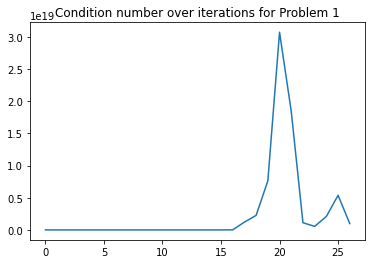

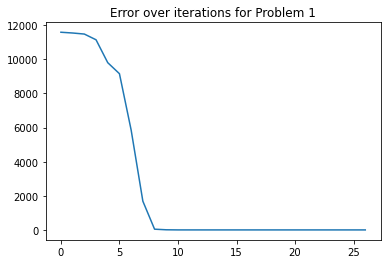

In [53]:
# Initialize the first problem -------------------------------------------------
G, g, A, b, C, d, x0, gamma0, lamb0, s0 = initialize_P1()
# Robustness of the method -----------------------------------------------------
z, n_iter, comp_time, kond, err = Newton_stepsize_full_S0_time(G, g, A, b, C, d, x0, gamma0, lamb0, s0, 1.15907181*1e4)
plt.figure()
plt.plot(np.arange(len(kond)), kond)
plt.title("Condition number over iterations for Problem 1")
plt.figure()
plt.plot(np.arange(len(err)), err)
plt.title("Error over iterations for Problem 1")

In [32]:
# Initialize the second problem ------------------------------------------------
def initialize_P2():
  n = 1000
  p = 500
  m = 2000

  G = read_matrix('/content/drive/MyDrive/10 - UB /20 - Colab Notebooks/UB Courses/Numerical Linear Algebra/Project_1/Problem2/G.dad', n, n).todense()
  G = G+G.T-np.diag(G)*np.eye(n)
  A = read_matrix('/content/drive/MyDrive/10 - UB /20 - Colab Notebooks/UB Courses/Numerical Linear Algebra/Project_1/Problem2/A.dad', n, p).todense()
  C = read_matrix('/content/drive/MyDrive/10 - UB /20 - Colab Notebooks/UB Courses/Numerical Linear Algebra/Project_1/Problem2/C.dad', n, m).todense()

  g = read_vector('/content/drive/MyDrive/10 - UB /20 - Colab Notebooks/UB Courses/Numerical Linear Algebra/Project_1/Problem2/g_vector.dad', n).reshape([n,1])
  b = read_vector('/content/drive/MyDrive/10 - UB /20 - Colab Notebooks/UB Courses/Numerical Linear Algebra/Project_1/Problem2/b.dad', p).reshape([p,1])
  d = read_vector('/content/drive/MyDrive/10 - UB /20 - Colab Notebooks/UB Courses/Numerical Linear Algebra/Project_1/Problem2/d.dad', m).reshape([m,1])

  x0 = np.zeros([n,1])
  gamma0 = np.ones([p,1])
  lamb0 = np.ones([m,1])
  s0 = np.ones([m,1])

  return G, g, A, b, C, d, x0, gamma0, lamb0, s0

In [33]:
# Check the solution -----------------------------------------------------------
def check_P2(G, g, z):
  
  # Retrieve the dimensions of the problem -------------------------------------
  n = G.shape[0]

  def f(G, g, x):
    return 1/2*(x.T).dot(G).dot(x)+(g.T).dot(x)

  Error = abs(1/2*(z[:n].T).dot(G).dot(z[:n])+(g.T).dot(z[:n])-1.08751157*1e6)
  return Error

In [59]:
# Initialize the second problem ------------------------------------------------
G, g, A, b, C, d, x0, gamma0, lamb0, s0 = initialize_P2()
# Run the method on the second problem -----------------------------------------
z, n_iter, kond, err = Newton_stepsize_full_S0(G, g, A, b, C, d, x0, gamma0, lamb0, s0, 1.08751157*1e6)
print("The method terminates in", n_iter, "iterations")
print("The obtained solution gives an error of: ")
print(check_P2(G, g, z))

KeyboardInterrupt: ignored

In [ ]:
# Computation time -------------------------------------------------------------
z, n_iter_S0_P2, comp_time_S0_P2, kond_S0_P2, err_S0_P2 = Newton_stepsize_full_S0_time(G, g, A, b, C, d, x0, gamma0, lamb0, s0, 1.08751157*1e6)
print("Number of iterations of S0 on P2: " + str(n_iter_S0_P2))
print("Time of execution of S0 on P2: " + str(comp_time_S0_P2), "ms")

Robustness of the method

In [60]:
# Initialize the second problem ------------------------------------------------
G, g, A, b, C, d, x0, gamma0, lamb0, s0 = initialize_P2()
# Robustness of the method -----------------------------------------------------
z, n_iter, comp_time, kond, err = Newton_stepsize_full_S0_time(G, g, A, b, C, d, x0, gamma0, lamb0, s0, 1.08751157*1e6)
plt.figure()
plt.plot(np.arange(len(kond)), kond)
plt.title("Condition number over iterations for Problem 2")
plt.figure()
plt.plot(np.arange(len(err)), err)
plt.title("Error over iterations for Problem 2")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


KeyboardInterrupt: ignored

## **C6:** Implement a routine that uses LDLT to solve the optimizations problems (in **C5**) and compare the results.


In [37]:
def compose_C6S1(G, A, C, lamb, s):
  ''' compose_C6S1
  Computes the matrix C6S1 to solve in order to compute the Newton step
  Given G, A, C, s, lamb, Returns the C6S1 Matrix
  '''

  # Retrieve the dimensions of the matrices ------------------------------------
  n = G.shape[0]
  p = A.shape[1]
  m = C.shape[1]

  C6S1 = np.block([
                  [G,               -A,              -C,                ],
                  [-A.T,            np.zeros([p,p]), np.zeros([p,m]),   ],
                  [-C.T,            np.zeros([m,p]), -s/lamb*np.eye(m), ],
                                                                        ])
  
  kond = cond(C6S1)
  
  return C6S1, kond

def update_C6S1(C6S1, lamb, s):
  ''' update_C6S1
  Updatess the matrix C6S1 to solve in order to compute the Newton step
  Given G, A, C, s, lamb, Returns the C6S1 Matrix
  '''

  # Retrieve the dimensions of the matrices ------------------------------------
  n = G.shape[0]
  p = A.shape[1]
  m = C.shape[1]

  C6S1[-m:, -m:] = -s/lamb*np.eye(m)

  kond = cond(C6S1)

  return C6S1, kond

In [38]:
# Defining a function to run the method ----------------------------------------
def Newton_stepsize_full_S1(G, g, A, b, C, d, x0, gamma0, lamb0, s0, ex_sol = 0, max_iter = 100, epsilon = 1e-16):
  ''' Newton step-size
  The method solves the KKT System using Newton's method with step-size correction
  Given G, g, A, b, C, d, x0, s0, lamb0, Returns the solution to the problem min(1/2*x.T*G*x + g.T*x)
  '''

  # Retrieve the dimensions of the matrices ------------------------------------
  n = G.shape[0]
  p = A.shape[1]
  m = C.shape[1]
  N = n+p+2*m

  # Initialization -------------------------------------------------------------
  z = np.concatenate((x0, gamma0, lamb0, s0), axis=None).reshape([N,1])
  kond = []
  err = []
  C6S1, kond_t = compose_C6S1(G, A, C, lamb0, s0)
  kond.append(kond_t)
  err.append(float(abs(1/2*(z[:n].T).dot(G).dot(z[:n])+(g.T).dot(z[:n])-ex_sol)))
  n_iter = 0
  delta = np.ones([N,1])      # Initialized in order to enter the loop, then immediately updated
  mu = 1          # Initialized in order to enter the loop, then updated

  # Method ---------------------------------------------------------------------
  while norm(delta[:n])>epsilon and norm(delta[n:n+m])>epsilon and norm(delta[n+m:])>epsilon and abs(mu)>epsilon and n_iter < max_iter:
    rhv = -F(G, g, A, b, C, d, z)     # Compute the right hand vector
    rhv2d = np.concatenate((rhv[:n+p], rhv[n+p:n+p+m]-rhv[-m:]/z[n+p:n+p+m]), axis=None).reshape([n+p+m,1])        # Right hand vector to solve C4S1

    L, D, perm = ldl(C6S1)
    invperm = np.empty(perm.size, dtype=np.int32)     # inverse permutation array
    for i in np.arange(perm.size):
      invperm[perm[i]] = i
    aux = solve_triangular(L[perm,:], rhv2d[perm], lower=True)
    aux = solve(D, aux)
    #aux = (aux)/(np.diag(D).reshape([n+m+p,1]))
    delta[:n+m+p] = solve_triangular(L.T[:,perm], aux, lower=False)[invperm]        # Compute delta_x,delta_gamma and delta_lambda
    delta[-m:] = (rhv[-m:]-z[-m:]*delta[n+p:n+p+m])/z[n+p:n+p+m]            # Compute the value of delta_s

    alpha = Newton_step(z[n+p:n+p+m].ravel(), delta[n+p:n+p+m].ravel(), z[n+p+m:].ravel(), delta[n+p+m:].ravel())       # compute the value of alpha

    mu = np.dot(z[n+p+m:].T,z[n+p:n+p+m])/m
    mu_tilda = np.dot((z[n+p+m:]+alpha*delta[n+p+m:]).T,z[n+p:n+p+m]+alpha*delta[n+p:n+p+m])/m
    sigma = (mu_tilda/mu)**3

    rhv[n+p+m:] = rhv[n+p+m:]-delta[n+p+m:]*delta[n+p:n+p+m]+sigma*mu*np.ones([m,1])         # Compute the modified right hand vector
    rhv2d = np.concatenate((rhv[:n+p], rhv[n+p:n+p+m]-rhv[-m:]/z[n+p:n+p+m]), axis=None).reshape([n+p+m,1])        # Right hand vector to solve C4S1

    L, D, perm = ldl(C6S1)
    invperm = np.empty(perm.size, dtype=np.int32)     # inverse permutation array
    for i in np.arange(perm.size):
      invperm[perm[i]] = i
    aux = solve_triangular(L[perm,:], rhv2d[perm], lower=True)
    aux = solve(D, aux)
    #aux = (aux)/(np.diag(D).reshape([n+m+p,1]))
    delta[:n+m+p] = solve_triangular(L.T[:,perm], aux, lower=False)[invperm]        # Compute delta_x,delta_gamma and delta_lambda
    delta[-m:] = (rhv[-m:]-z[-m:]*delta[n+p:n+p+m])/z[n+p:n+p+m]            # Compute the value of delta_s

    alpha = Newton_step(z[n+p:n+p+m].ravel(), delta[n+p:n+p+m].ravel(), z[n+p+m:].ravel(), delta[n+p+m:].ravel())       # Update the value of alpha

    z = z + 0.95*alpha*delta              # take one step of the method
    C6S1, kond_t = update_C6S1(C6S1, z[n+p:n+p+m], z[n+p+m:])          # Update the MKKT matrix
    kond.append(kond_t)
    err.append(float(abs(1/2*(z[:n].T).dot(G).dot(z[:n])+(g.T).dot(z[:n])-ex_sol)))
    n_iter = n_iter+1

  return z, n_iter, kond, err

In [39]:
import time

# Defining a function to run the method ----------------------------------------
def Newton_stepsize_full_S1_time(G, g, A, b, C, d, x0, gamma0, lamb0, s0, ex_sol = 0, max_iter = 100, epsilon = 1e-16):
  ''' Newton step-size
  The method solves the KKT System using Newton's method with step-size correction
  Given G, g, A, b, C, d, x0, s0, lamb0, Returns the solution to the problem min(1/2*x.T*G*x + g.T*x)
  '''

  # Start the timer ------------------------------------------------------------
  start = time.time()

  # Run the method -------------------------------------------------------------
  z, n_iter, kond, err = Newton_stepsize_full_S1(G, g, A, b, C, d, x0, gamma0, lamb0, s0, ex_sol, max_iter, epsilon)

  # Stop the timer and print the time elapsed ----------------------------------
  end = time.time()
  comp_time = (end-start)*(10**3)

  return z, n_iter, comp_time, kond, err

In [40]:
# Initialize the first problem -------------------------------------------------
G, g, A, b, C, d, x0, gamma0, lamb0, s0 = initialize_P1()
# Run the method on the second problem -----------------------------------------
z, n_iter, kond, err = Newton_stepsize_full_S1(G, g, A, b, C, d, x0, gamma0, lamb0, s0, 1.15907181*1e4)
print("The method terminates in", n_iter, "iterations")
print("The obtained solution gives an error of: ")
print(check_P1(G, g, z))

The method terminates in 25 iterations
The obtained solution gives an error of: 
[[1.9426765e-05]]


In [41]:
# Computation time -------------------------------------------------------------
z, n_iter, comp_time, kond, err = Newton_stepsize_full_S1_time(G, g, A, b, C, d, x0, gamma0, lamb0, s0, 1.15907181*1e4)
print("Number of iterations of S1 on P1: " + str(n_iter))
print("Time of execution of S1 on P1: " + str(comp_time), "ms")

Number of iterations of S1 on P1: 25
Time of execution of S1 on P1: 2043.142557144165 ms


Robustness of the method

Text(0.5, 1.0, 'Error over iterations for Problem 1')

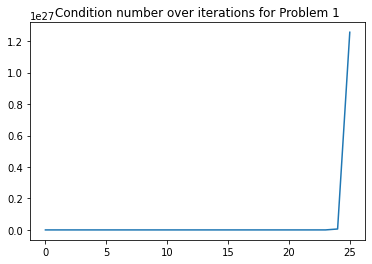

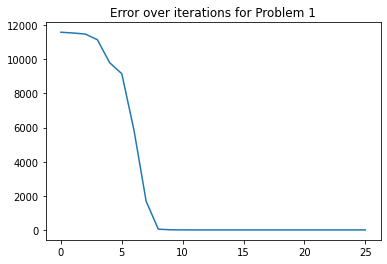

In [42]:
# Initialize the first problem -------------------------------------------------
G, g, A, b, C, d, x0, gamma0, lamb0, s0 = initialize_P1()
# Robustness of the method -----------------------------------------------------
z, n_iter, comp_time, kond, err = Newton_stepsize_full_S1_time(G, g, A, b, C, d, x0, gamma0, lamb0, s0, 1.15907181*1e4)
plt.figure()
plt.plot(np.arange(len(kond)), kond)
plt.title("Condition number over iterations for Problem 1")
plt.figure()
plt.plot(np.arange(len(err)), err)
plt.title("Error over iterations for Problem 1")

In [323]:
# Initialize the second problem ------------------------------------------------
G, g, A, b, C, d, x0, gamma0, lamb0, s0 = initialize_P2()
# Run the method on the second problem -----------------------------------------
z, n_iter, kond, err = Newton_stepsize_full_S0(G, g, A, b, C, d, x0, gamma0, lamb0, s0, 1.08751157*1e6)
print("The method terminates in", n_iter, "iterations")
print("The obtained solution gives an error of: ")
print(check_P2(G, g, z))

The method terminates in 29 iterations
The obtained solution gives an error of: 
[[0.0026785]]


In [324]:
# Computation time -------------------------------------------------------------
z, n_iter, comp_time, kond, err = Newton_stepsize_full_S1_time(G, g, A, b, C, d, x0, gamma0, lamb0, s0, 1.08751157*1e6)
print("Number of iterations of S1 on P2: " + str(n_iter))
print("Time of execution of S1 on P2: " + str(comp_time), "ms")

Number of iterations of S1 on P2: 29
Time of execution of S1 on P2: 132751.11317634583 ms


In [43]:
def is_diagonal(D):
  for i in range(0,D.shape[0]):
    for j in range(0,D.shape[1]):
      if D[i,j]!=0 and i!=j:
        return False
  return True

In [44]:
def solve_diag_blocks(D, aux):

  dim = D.shape[0]
  subdiag = np.diag(D, -1)
  skip=False
  
  for i in range(0, dim-1):
    if skip==True:
      skip=False
      continue
    elif subdiag[i]==0:
      aux[i]=aux[i]/D[i,i]
    else:
      aux[i:i+2]=solve(D[i:i+2,i:i+2],aux[i:i+2])
      skip=True

  if subdiag[-1]==0:
    aux[-1]=aux[-1]/D[-1,-1]

  return aux

In [45]:
# Defining a function to run the method ----------------------------------------
def Newton_stepsize_full_S1_OPT(G, g, A, b, C, d, x0, gamma0, lamb0, s0, ex_sol = 0, max_iter = 100, epsilon = 1e-16):
  ''' Newton step-size
  The method solves the KKT System using Newton's method with step-size correction
  Given G, g, A, b, C, d, x0, s0, lamb0, Returns the solution to the problem min(1/2*x.T*G*x + g.T*x)
  '''

  # Retrieve the dimensions of the matrices ------------------------------------
  n = G.shape[0]
  p = A.shape[1]
  m = C.shape[1]
  N = n+p+2*m

  # Initialization -------------------------------------------------------------
  z = np.concatenate((x0, gamma0, lamb0, s0), axis=None).reshape([N,1])
  kond = []
  err = []
  C6S1, kond_t = compose_C6S1(G, A, C, lamb0, s0)
  kond.append(kond_t)
  err.append(float(abs(1/2*(z[:n].T).dot(G).dot(z[:n])+(g.T).dot(z[:n])-ex_sol)))
  n_iter = 0
  delta = np.ones([N,1])      # Initialized in order to enter the loop, then immediately updated
  mu = 1          # Initialized in order to enter the loop, then updated

  # Method ---------------------------------------------------------------------
  while norm(delta[:n])>epsilon and norm(delta[n:n+m])>epsilon and norm(delta[n+m:])>epsilon and abs(mu)>epsilon and n_iter < max_iter:
    rhv = -F(G, g, A, b, C, d, z)     # Compute the right hand vector
    rhv2d = np.concatenate((rhv[:n+p], rhv[n+p:n+p+m]-rhv[-m:]/z[n+p:n+p+m]), axis=None).reshape([n+p+m,1])        # Right hand vector to solve C4S1

    L, D, perm = ldl(C6S1)
    invperm = np.empty(perm.size, dtype=np.int32)     # inverse permutation array
    for i in np.arange(perm.size):
      invperm[perm[i]] = i
    aux = solve_triangular(L[perm,:], rhv2d[perm], lower=True)
    aux = solve_diag_blocks(D, aux)
    #aux = solve(D, aux)
    delta[:n+m+p] = solve_triangular(L.T[:,perm], aux, lower=False)[invperm]        # Compute delta_x,delta_gamma and delta_lambda
    delta[-m:] = (rhv[-m:]-z[-m:]*delta[n+p:n+p+m])/z[n+p:n+p+m]            # Compute the value of delta_s

    alpha = Newton_step(z[n+p:n+p+m].ravel(), delta[n+p:n+p+m].ravel(), z[n+p+m:].ravel(), delta[n+p+m:].ravel())       # compute the value of alpha

    mu = np.dot(z[n+p+m:].T,z[n+p:n+p+m])/m
    mu_tilda = np.dot((z[n+p+m:]+alpha*delta[n+p+m:]).T,z[n+p:n+p+m]+alpha*delta[n+p:n+p+m])/m
    sigma = (mu_tilda/mu)**3

    rhv[n+p+m:] = rhv[n+p+m:]-delta[n+p+m:]*delta[n+p:n+p+m]+sigma*mu*np.ones([m,1])         # Compute the modified right hand vector
    rhv2d = np.concatenate((rhv[:n+p], rhv[n+p:n+p+m]-rhv[-m:]/z[n+p:n+p+m]), axis=None).reshape([n+p+m,1])        # Right hand vector to solve C4S1

    L, D, perm = ldl(C6S1)
    invperm = np.empty(perm.size, dtype=np.int32)     # inverse permutation array
    for i in np.arange(perm.size):
      invperm[perm[i]] = i
    aux = solve_triangular(L[perm,:], rhv2d[perm], lower=True)
    aux = solve_diag_blocks(D, aux)
    #aux = solve(D, aux)
    delta[:n+m+p] = solve_triangular(L.T[:,perm], aux, lower=False)[invperm]        # Compute delta_x,delta_gamma and delta_lambda
    delta[-m:] = (rhv[-m:]-z[-m:]*delta[n+p:n+p+m])/z[n+p:n+p+m]            # Compute the value of delta_s

    alpha = Newton_step(z[n+p:n+p+m].ravel(), delta[n+p:n+p+m].ravel(), z[n+p+m:].ravel(), delta[n+p+m:].ravel())       # Update the value of alpha

    z = z + 0.95*alpha*delta              # take one step of the method
    C6S1, kond_t = update_C6S1(C6S1, z[n+p:n+p+m], z[n+p+m:])          # Update the MKKT matrix
    kond.append(kond_t)
    err.append(float(abs(1/2*(z[:n].T).dot(G).dot(z[:n])+(g.T).dot(z[:n])-ex_sol)))
    n_iter = n_iter+1

  return z, n_iter, kond, err

In [46]:
import time

# Defining a function to run the method ----------------------------------------
def Newton_stepsize_full_S1_OPT_time(G, g, A, b, C, d, x0, gamma0, lamb0, s0, ex_sol = 0, max_iter = 100, epsilon = 1e-16):
  ''' Newton step-size
  The method solves the KKT System using Newton's method with step-size correction
  Given G, g, A, b, C, d, x0, s0, lamb0, Returns the solution to the problem min(1/2*x.T*G*x + g.T*x)
  '''

  # Start the timer ------------------------------------------------------------
  start = time.time()

  # Run the method -------------------------------------------------------------
  z, n_iter, kond, err = Newton_stepsize_full_S1_OPT(G, g, A, b, C, d, x0, gamma0, lamb0, s0, ex_sol, max_iter, epsilon)

  # Stop the timer and print the time elapsed ----------------------------------
  end = time.time()
  comp_time = (end-start)*(10**3)

  return z, n_iter, comp_time, kond, err

In [47]:
# Initialize the first problem -------------------------------------------------
G, g, A, b, C, d, x0, gamma0, lamb0, s0 = initialize_P1()
# Run the method on the second problem -----------------------------------------
z, n_iter, kond, err = Newton_stepsize_full_S1_OPT(G, g, A, b, C, d, x0, gamma0, lamb0, s0, 1.15907181*1e4)
print("The method terminates in", n_iter, "iterations")
print("The obtained solution gives an error of: ")
print(check_P1(G, g, z))

The method terminates in 25 iterations
The obtained solution gives an error of: 
[[1.9426765e-05]]


In [48]:
# Computation time -------------------------------------------------------------
z, n_iter, comp_time, kond, err = Newton_stepsize_full_S1_OPT_time(G, g, A, b, C, d, x0, gamma0, lamb0, s0, 1.15907181*1e4)
print("Number of iterations of S1 on P1: " + str(n_iter))
print("Time of execution of S1 on P1: " + str(comp_time), "ms")

Number of iterations of S1 on P1: 25
Time of execution of S1 on P1: 1327.726125717163 ms


Text(0.5, 1.0, 'Error over iterations for Problem 1')

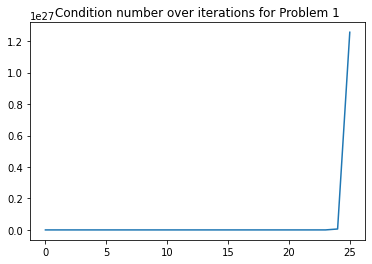

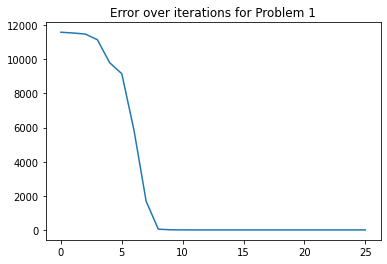

In [49]:
# Initialize the first problem -------------------------------------------------
G, g, A, b, C, d, x0, gamma0, lamb0, s0 = initialize_P1()
# Robustness of the method -----------------------------------------------------
z, n_iter, comp_time, kond, err = Newton_stepsize_full_S1_OPT_time(G, g, A, b, C, d, x0, gamma0, lamb0, s0, 1.15907181*1e4)
plt.figure()
plt.plot(np.arange(len(kond)), kond)
plt.title("Condition number over iterations for Problem 1")
plt.figure()
plt.plot(np.arange(len(err)), err)
plt.title("Error over iterations for Problem 1")

In [331]:
# Initialize the second problem ------------------------------------------------
G, g, A, b, C, d, x0, gamma0, lamb0, s0 = initialize_P2()
# Run the method on the second problem -----------------------------------------
z, n_iter, kond, err = Newton_stepsize_full_S1_OPT(G, g, A, b, C, d, x0, gamma0, lamb0, s0, 1.08751157*1e6)
print("The method terminates in", n_iter, "iterations")
print("The obtained solution gives an error of: ")
print(check_P2(G, g, z))

The method terminates in 29 iterations
The obtained solution gives an error of: 
[[0.0026785]]


In [332]:
# Computation time -------------------------------------------------------------
z, n_iter, comp_time, kond, err = Newton_stepsize_full_S1_OPT_time(G, g, A, b, C, d, x0, gamma0, lamb0, s0, 1.08751157*1e6)
print("Number of iterations of S1_OPT on P2: " + str(n_iter))
print("Time of execution of S1_OPT on P2: " + str(comp_time), "ms")

Number of iterations of S1_OPT on P2: 29
Time of execution of S1_OPT on P2: 67621.821641922 ms
